<a href="https://colab.research.google.com/github/carson-edmonds/AAI-590_Group-3_Capstone/blob/jeremy_dev/ViT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center">Airborne Object Tracking - Exploratory Data Analysis</h1>

####Accessing the dataset involved the following code that was referenced in the AOT challenge website: https://www.aicrowd.com/challenges/airborne-object-tracking-challenge and with the tutorial code created by Vuong Tuan Khanh at: https://github.com/VuongTuanKhanh/Airborne-Object-Detection-and-Tracking

# Imports

In [1]:
import json
import random
import os, sys
from IPython.display import display, clear_output, HTML
from random import randrange, choice
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=25,25
import numpy as np
import seaborn as sns

random.seed(42)

def mdprint(text):
    display({
        'text/markdown': text,
        'text/plain': text
    }, raw=True)

!git clone https://github.com/VuongTuanKhanh/Funix-Capstone-Project.git

os.mkdir("Funix-Capstone-Project/data")
os.chdir("Funix-Capstone-Project/data")

Cloning into 'Funix-Capstone-Project'...
remote: Enumerating objects: 528, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 528 (delta 2), reused 2 (delta 0), pack-reused 519
Receiving objects: 100% (528/528), 406.22 MiB | 12.99 MiB/s, done.
Resolving deltas: 100% (167/167), done.
Updating files: 100% (172/172), done.


## Loading Dataset (Part 1 only)

**NOTE**: You don't need to have `groundtruth.json` pre-downloaded, it will automatically download, save and load them for you.

In [ ]:
# Dataset for Airborne Object Tracking Dataset
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())) + "/core")

!pip install -r ../requirements.txt > /dev/null

from core.dataset import Dataset
notebook_path = os.path.dirname(os.path.realpath("__file__"))

local_path = notebook_path + '/part1'
s3_path = 's3://airborne-obj-detection-challenge-training/part1/'
dataset = Dataset(local_path, s3_path, partial=True, prefix='part1')
dataset.add(local_path, s3_path)

## Ground Truth Structure

Ground truth (present in `ImageSets` folder) contains all the relevant information regarding airborne objects, their locations, bbox and so on.
While the `Images` folder have accompanied images for your training code to work on.

Before we start, let's check the vocabulary we will need to understand the dataset:

* `flights` (a.k.a. `samples` in ground truth):<br>
  One flight is typically 2 minutes video at 10 fps i.e. 1200 images. Each of the frames are present in `Images/{{flight_id}}/` folder. These files are typically 3-4mb each.


* `frame` (a.k.a. `entity` in ground truth):<br>
  This is the most granular unit on which dataset can be sampled. Each frame have information timestamp, frame_id, and label `is_above_horizon`.
  There can be multiple entries for same frame in `entity` when multiple Airborne objects are present.<br>
  When an Airborne object following information is available as well:
  - `id` -> signifies unique ID of this object (for whole frame)
  - `bbox` -> it contains 4 floats signifying `[left, top, width, height]`
  - `blob['range_distance_m']` -> distance of airborne object
  - `labels['is_above_horizon']` -> details below
  - (derived) `planned` -> for the planned objects `range_distance_m` is available
    

* `is_above_horizon`:<br>
  It is marked as 1 when Airborne object is above horizon and -1 when it is below horizon. When unclear, it is marked as 0.

Example for frame level data (multiple per frame):

```json
{
    'time': 1550844897919368155,
    'blob': {
        'frame': 480,
        'range_distance_m': nan # signifies, it was an unplanned object
    },
    'id': 'Bird2',
    'bb': [1013.4, 515.8, 6.0, 6.0],
    'labels': {'is_above_horizon': 1},
    'flight_id': '280dc81adbb3420cab502fb88d6abf84',
    'img_name': '1550844897919368155280dc81adbb3420cab502fb88d6abf84.png'
}
```

In [7]:
# Keys
def remove_numbers(s):
  return ''.join([i for i in s if not i.isdigit()])

all_keys = []
for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    all_keys.extend([remove_numbers(k) for k in flight.detected_objects])

unique_keys = list(set(all_keys))
unique_keys

['Flock', 'Bird', 'Drone', 'Airplane', 'Helicopter', 'Airborne']

## Loading dataset as a Pandas df

In [8]:
rows = []
for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj_key in flight.detected_objects:
        object_type = remove_numbers(obj_key)
        obj = flight.detected_objects[obj_key]
        for loc in obj.location:
            bbox = loc.bb.get_bbox()
            frame_id = loc.frame.id
            range_distance = loc.range_distance_m
            image_path = loc.frame.image_path()
            rows.append([flight_id, object_type, obj_key, frame_id,
                         *bbox, bbox[-1]*bbox[-2], image_path, range_distance])

In [9]:
import pandas as pd
# converting the rows array to a dataframe
df = pd.DataFrame(rows)
df.columns = ['flight_id', 'object_type', 'object', 'frame_id',
              'left', 'top', 'width', 'height', 'area', 'image_path','range_distance']
df.head()

,flight_id,object_type,object,frame_id,left,top,width,height,area,image_path,range_distance
0,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,105,1414.4,1180.0,27.0,7.2,194.40,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,699.080159
1,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,106,1416.6,1174.8,28.6,6.6,188.76,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,692.630062
2,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,107,1417.4,1171.4,29.2,7.6,221.92,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,686.419015
3,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,108,1418.8,1172.4,28.8,7.0,201.60,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,679.760444
4,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,109,1422.0,1167.4,29.4,6.8,199.92,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,673.387413


###EDA:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167721 entries, 0 to 167720
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   flight_id       167721 non-null  object 
 1   object_type     167721 non-null  object 
 2   object          167721 non-null  object 
 3   frame_id        167721 non-null  int64  
 4   left            167721 non-null  float64
 5   top             167721 non-null  float64
 6   width           167721 non-null  float64
 7   height          167721 non-null  float64
 8   area            167721 non-null  float64
 9   image_path      167721 non-null  object 
 10  range_distance  138530 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 14.1+ MB


In [11]:
df.describe()

,frame_id,left,top,width,height,area,range_distance
count,167721.000000,167721.000000,167721.000000,167721.000000,167721.000000,167721.000000,138530.000000
mean,591.441638,1405.633238,1037.953850,31.584007,22.673507,1293.497617,360.304547
std,335.242692,535.724915,273.318472,34.548935,20.949872,5664.568288,158.403471
min,2.000000,0.000000,0.000000,2.000000,3.200000,12.000000,0.003613
25%,302.000000,1064.748413,913.440002,16.000000,16.000000,256.000000,243.370269
50%,592.000000,1459.722046,1059.914712,18.400000,16.000000,322.390206,336.726191
75%,880.000000,1796.412842,1186.446899,37.688843,24.400000,806.666667,475.468654
max,1202.000000,2445.000000,2043.243243,702.919708,404.377441,216157.907819,699.990292


In [12]:
df.shape

(167721, 11)

In [13]:
object_types = df['object_type'].value_counts()
object_types

object_type
Helicopter    115916
Airplane       31358
Airborne       12043
Bird            7169
Flock            907
Drone            328
Name: count, dtype: int64

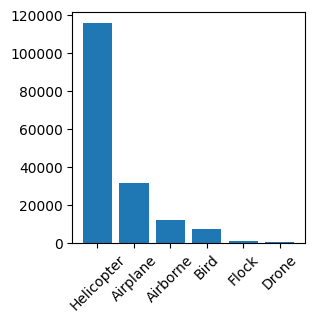

In [17]:
plt.bar(object_types.index, object_types.values)
plt.rcParams['figure.figsize'] = [3, 3]
plt.xticks(rotation=45)
plt.show()

## Download images for training

Filter data points by relevant airborne objects (Airplane, Helicopter) and pick objects larger than a certain value. This picks images of 5000 Airplanes and 5000 helicopters for training.

In [20]:
import random
filtered_df = df.loc[((df['object_type'] == 'Helicopter') | (df['object_type'] == 'Airplane'))]
filtered_df = filtered_df.loc[df['area'] > 400]
flights = filtered_df.index[(filtered_df['object_type'] == 'Airplane')]
helicopters = filtered_df.index[(filtered_df['object_type'] == 'Helicopter')]
counts_dict = dict(filtered_df['image_path'].value_counts())
multi_object_frames = filtered_df[filtered_df.apply(lambda x:counts_dict[x['image_path']] > 1, axis=1)].index
train_indices = random.sample(list(flights),5000) + random.sample(list(helicopters),5000)
train_df = filtered_df.loc[list(set(train_indices))]
filtered_df.head()

,flight_id,object_type,object,frame_id,left,top,width,height,area,image_path,range_distance
23,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,128,1458.0,1143.0,36.6,11.6,424.56,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,551.537168
25,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,130,1467.4,1143.2,39.4,11.0,433.40,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,538.716655
27,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,132,1478.0,1140.0,37.4,10.8,403.92,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,525.940516
31,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,136,1481.0,1139.0,42.4,11.8,500.32,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,500.168346
32,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,137,1481.4,1137.6,41.4,10.8,447.12,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,493.715561


Downloading select images (2 min : 30 sec)

In [21]:
download_images = []
for idx in range(len(train_df)):
  flight = dataset.flights[train_df.iloc[idx]['flight_id']]
  frame = flight.frames[train_df.iloc[idx]['frame_id']]
  image_path = frame.image_path()
  s3_path = frame.image_s3_path()
  download_images.append([image_path, image_path])
random.shuffle(download_images)

from tqdm import tqdm
for idx in tqdm(range(100)):
  dataset.file_handler.download_from_s3_parallel(download_images[idx])

100%|██████████| 100/100 [02:31<00:00,  1.52s/it]


## Image Visualization

<ipython-input-23-ba4367b266c9>:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  frame_df = train_df[df["image_path"] == target_image]


1585 891 1605 917


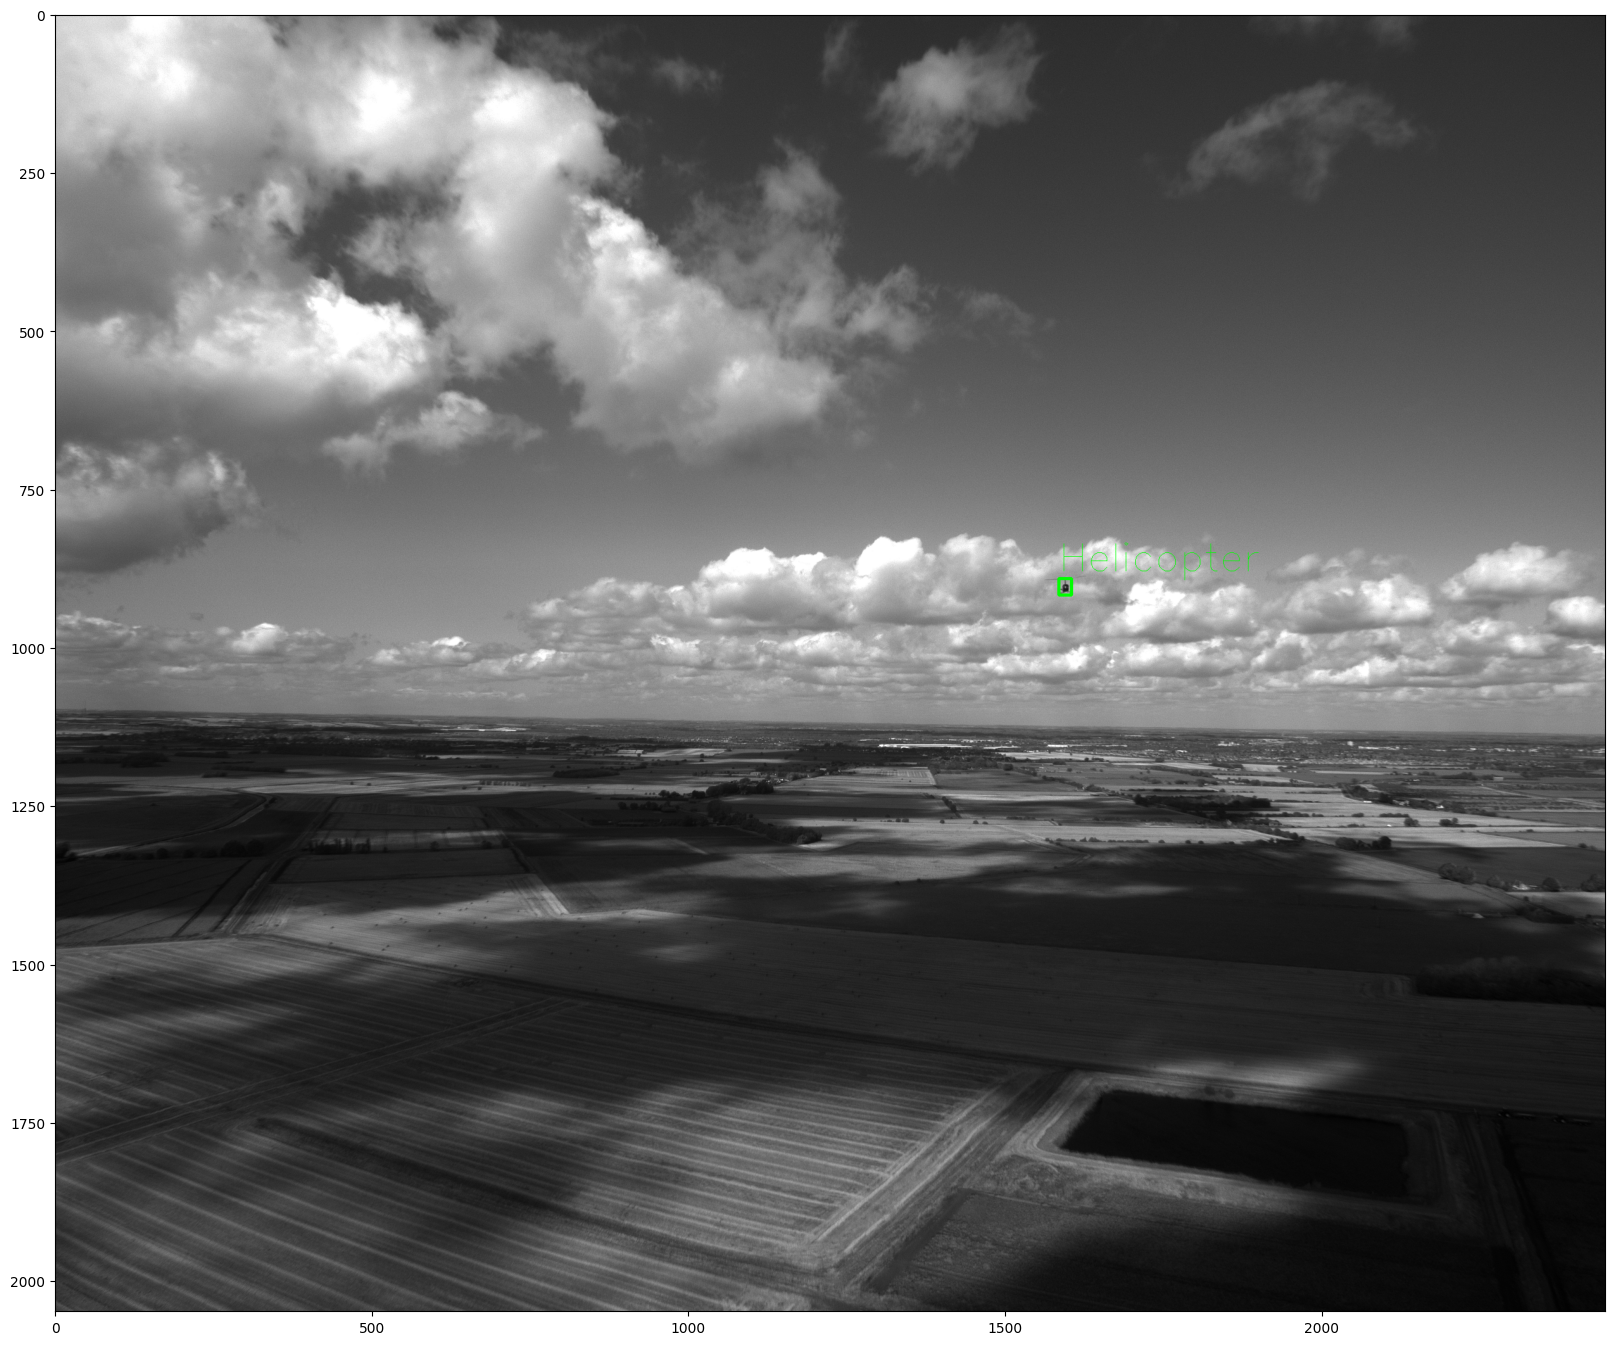

In [23]:
import cv2
import sys
%matplotlib inline
plt.rcParams["figure.figsize"] = 20, 20 # Adjust size of image
def drawBoundingBoxes(imageInputPath, imageOutputPath, inferenceResults, color):
    """Draw bounding boxes on an image.
    imageData: image data in numpy array format
    imageOutputPath: output image file path
    inferenceResults: inference results array off object (l,t,w,h)
    colorMap: Bounding box color candidates, list of RGB tuples.
    """
    imageData = cv2.imread(imageInputPath)
    for res in inferenceResults:
        left = int(res['left'])
        top = int(res['top'])
        right = int(res['left']) + int(res['width'])
        bottom = int(res['top']) + int(res['height'])
        label = res['label']
        imgHeight, imgWidth, _ = imageData.shape
        thick = int((imgHeight + imgWidth) // 900)
        print (left, top, right, bottom)
        cv2.rectangle(imageData,(left, top), (right, bottom), color, thick)
        cv2.putText(imageData, label, (left, top - 12), 0, 1e-3 * imgHeight, color, thick//3)
    plt.imshow(imageData)

target_image = download_images[0][0]
color = (0,255,0)
img_root = 'part1'
frame_df = train_df[df["image_path"] == target_image]
boxes = []
for idx,ob in frame_df.iterrows():
  label,left,top,width,height = ob['object_type'],ob['left'],ob['top'],ob['width'],ob['height']
  box = {}
  box['left'] = left
  box['top'] = top
  box['width'] = width
  box['height'] = height
  box['label'] = label
  boxes.append(box)

drawBoundingBoxes(os.path.join(img_root,target_image),'output.png',boxes,color)


## Setup for training